# Clustering with K-Means

Clustering analysis is one of approaches to unsupervised learning. It groups data in such a way that objects in the same group/cluster are similar to each other and objects in different clusters diverge.

There are many algorithms implementing cluster analysis with different ideas behind them. K-Means is one of the most used.

At first I'll try K-Means algorithm from sklearn. Then I'll write a simple clustering algorithm. After that I'll show how high-dimensional data may be visualized.

1. [K-Means clustering](#kmeans)
2. [K-Means clustering with two variables](#kmeans_2)
3. [Implementation of KMeans](#manual)
4. [Voronoi diagram](#voron)
5. [High-dimensional data visualization](#manyd)

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.datasets.samples_generator import make_blobs
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import classification_report

## <a name="kmeans">K-Means clustering</a>

K-Means clusters data by grouping the samples in groups of equal variance by minimizing within-cluster sum-of-squares.
$$ \sum_{i=0}^{n} \min_{\\\mu_i \in C} (||x_i - \mu_i||)^2 $$

The steps of the algorithm are the following:

* Set initial centroids (starting points);
* Assign samples to the nearest centroids;
* Take means of all samples assigned to centroids and create new centroids with these vales;
* Repeat two previous steps until centroids stop moving significantly;

K-Means always converges, but sometimes to local minimum. That's why algorithm is usually run several times with different initial centroids.

Number of clasters must be specified, so if we don't know how many clusters exist in the data, then algorithm should be run with various number of clusters to find the best match.

But the serious advantage is that algorithm is simple and can be easily optimised, which allows to run it even on big datasets.

In this notebook I use [dataset](https://archive.ics.uci.edu/ml/datasets/seeds) with information about seeds. Most of the variables are self-explanatory; length_g - length of kernel groove.

In [2]:
header = ['area', 'perimeter', 'compactness', 'length', 'width', 'asymmetry', 'length_g', 'type']
seeds = pd.read_csv('../input/seeds_dataset.txt', delimiter='\t+', names=header, engine='python')

In [3]:
seeds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 8 columns):
area           210 non-null float64
perimeter      210 non-null float64
compactness    210 non-null float64
length         210 non-null float64
width          210 non-null float64
asymmetry      210 non-null float64
length_g       210 non-null float64
type           210 non-null int64
dtypes: float64(7), int64(1)
memory usage: 13.2 KB


No missing values and all columns are numerical.

In [4]:
seeds.head()

,area,perimeter,compactness,length,width,asymmetry,length_g,type
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


In [5]:
#There are three unique types of seeds. I take array of data so that it will be easier to compare with the results of clustering.
np.array(seeds.type)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3], dtype=int64)

In [6]:
#I know that there are 3 clusters, so I can run KMeans to find 3 clusters in data.
km = KMeans(n_clusters=3, n_jobs=-1)
kmeans_pred = km.fit_predict(seeds.drop(['type'], axis=1))
kmeans_pred

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 0, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2,
       2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 0])

In [7]:
#Labels created by KMeans don't correspond to the original (obviously), so they need to be changed manually. 
for i in range(len(kmeans_pred)):
    if kmeans_pred[i] == 2:
        kmeans_pred[i] = 1
    elif kmeans_pred[i] == 0:
        kmeans_pred[i] = 3
    elif kmeans_pred[i] == 1:
        kmeans_pred[i] = 2

In [8]:
print('Accuracy of clustering is ' + '{}{}'.format(round(100 * sum(kmeans_pred == seeds.type) / len(seeds.type), 2), '%'))

Accuracy of clustering is 89.52%


In [9]:
print(classification_report(seeds.type, kmeans_pred, target_names=['1', '2', '3'], digits=4))

             precision    recall  f1-score   support

          1     0.8333    0.8571    0.8451        70
          2     0.9836    0.8571    0.9160        70
          3     0.8831    0.9714    0.9252        70

avg / total     0.9000    0.8952    0.8954       210



Precision is the fraction of retrieved instances that are relevant and recall is the fraction of relevant instances that are retrieved. So for second class 98% of predictions were correct and for third class 97% of labels were predicted correctly.

So the data can be separated into clusters with a good accuracy.

## <a name="kmeans_2">K-Means clustering with two variables</a>

Not let's try clustering for only two variables so that we can visualize it.

In [10]:
seeds_small = seeds[['area', 'length']]
pred_small = km.fit_predict(seeds_small)

In [11]:
seed_target = np.array(seeds.type)
seed_target

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3], dtype=int64)

In [12]:
pred_small

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2,
       0, 2, 2, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 0, 0, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2,
       0, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2,
       2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0])

In [13]:
#Now I change the target's values so that the range of values is [0, 1, 2] - to use them as iteration of the list of colors.
for i in range(len(seed_target)):
    if seed_target[i] == 1:
        seed_target[i] = 2
    elif seed_target[i] == 3:
        seed_target[i] = 0
    else:
        seed_target[i] = 1

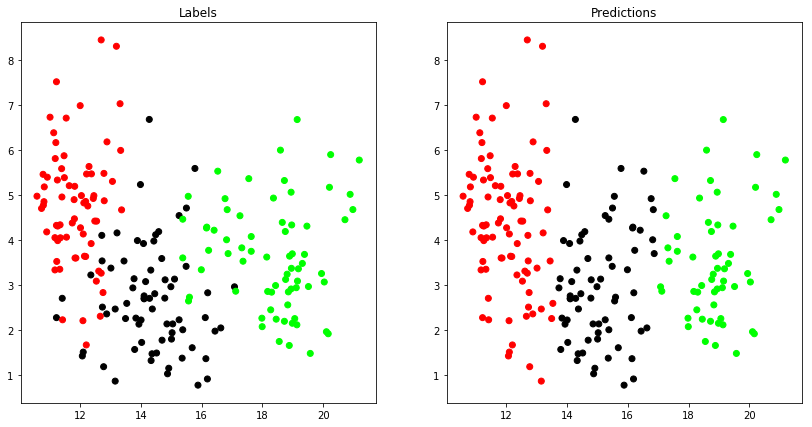

In [14]:
plt.figure(figsize=(14,7))
 
colormap = np.array(['red', 'lime', 'black'])
 
plt.subplot(1, 2, 1)
plt.scatter(seeds.area, seeds.asymmetry, c=colormap[seed_target])
plt.title('Labels')
 
plt.subplot(1, 2, 2)
plt.scatter(seeds.area, seeds.asymmetry, c=colormap[pred_small])
plt.title('Prediсtions')

In [15]:
print('Accuracy of clustering is ' + '{}{}'.format(round(100*sum(pred_small == seed_target) / len(seed_target), 2), '%'))

Accuracy of clustering is 84.29%


Scatterplot is a good representation of the fact that clustering gives the results very similar to true classification.

And in this case it seems that two vaiables are enough to cluster data with a good accuracy.

### <a name="manual">Implementation of KMeans</a>
Now I'll implement an algorithm similar to KMeans manually. It is based on Andrew NG's course on Coursera.

In [16]:
#I'll use only two variables at first for visualization.
X = np.array(seeds[['area', 'asymmetry']])

In [17]:
#There are 3 clusters and two variables. Set initial centroids with some values.
first_centroids = np.array([[12, 4], [18,5], [19,3]])

In [18]:
#Visualizing the data
def clus_col(X, centroids, preds):
    """
    Function to assign colors to clusters.
    """
    for x in range(centroids[0].shape[0]):
        yield (np.array([X[i] for i in range(X.shape[0]) if preds[i] == x]))

def draw_hist(h, centroids):
    """
    Data for plotting history
    """
    for centroid in centroids:
        yield (centroid[:,h])
            
            
def plot_clust(X, centroids, preds=None):
    #Number of colors shoud be equal to the number of clusters, so add more if necessary.
    colors = ['green', 'fuchsia', 'tan']
    
    #If clusters are defined (preds != None), colors are assigned to clusters.    
    clust = [X] if preds is None else list(clus_col(X, centroids, preds))
    
    #Plot clusters
    fig = plt.figure(figsize=(7, 5))
    for i in range(len(clust)):
        plt.plot(clust[i][:,0], clust[i][:,1], 'o', color=colors[i], alpha=0.75, label='Cluster %d'%i)
    plt.xlabel('area')
    plt.ylabel('asymmetry')

    #Plot history of centroids.
    tempx = list(draw_hist(0, centroids))
    tempy = list(draw_hist(1, centroids))
    
    for x in range(len(tempx[0])):
        plt.plot(tempx, tempy, 'ro--', markersize=6)

    leg = plt.legend(loc=4)

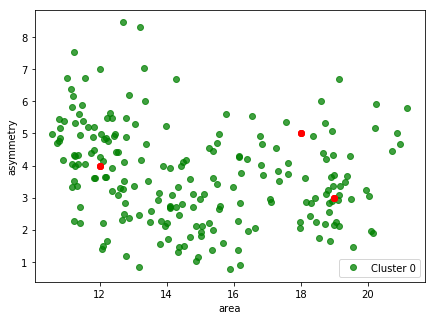

In [19]:
#Scatterplot with initial centroids.
plot_clust(X,[first_centroids])

Now the algorithm itself. At first closest centroids are found for each point in data. Then means of samples assigned to each centroid are calculated and new centroids are created with these values. These steps are repeated. I could define a threshold so that iterations stop when centroids move for lesser distance than threshold level, but even current implementation is good enough.

In [20]:
def find_centroids(X, centroids):
    preds = np.zeros((X.shape[0], 1))
    for j in range(preds.shape[0]):

        dist, label = 9999999, 0
        for i in range(centroids.shape[0]):
            distsquared = np.sum(np.square(X[j] - centroids[i]))
            if distsquared < dist:
                dist = distsquared
                label = i

        preds[j] = label
        
    return preds

In [21]:
def calc_centroids(X, preds):
    """
    Calculate new centroids
    """
    
    for x in range(len(np.unique(preds))):
        yield np.mean((np.array([X[i] for i in range(X.shape[0]) if preds[i] == x])), axis=0)

In [22]:
def iters(X, first_centroids, K, n_iter):
    centroid_history = []
    current_centroids = first_centroids
    for iter in range(n_iter):
        centroid_history.append(current_centroids)
        preds = find_centroids(X, current_centroids)
        current_centroids = np.array(list(calc_centroids(X, preds)))
    return preds, centroid_history

In [23]:
preds, centroid_history = iters(X, first_centroids, 3, 20)

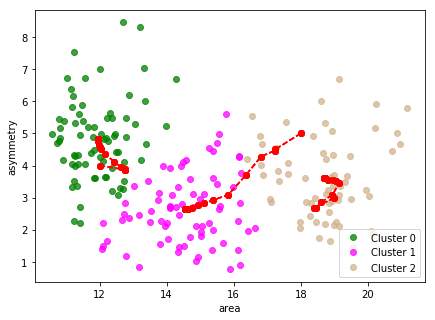

In [24]:
plot_clust(X,centroid_history,preds)

This is how the process of finding optimal centroids looks like. From initial points centroids move to optimize the loss function. As a result there are three distinguishable clusters.
___
Now let's try to predict labels using all variables.

In [25]:
first_centroids = np.array([[12, 13, 0.85, 6, 2, 4, 4], [18, 15, 0.9, 6, 3, 5, 5], [19, 14, 0.9, 5.8, 2, 3, 6]])
X = np.array(seeds.drop(['type'], axis=1))

In [26]:
preds, centroid_history = iters(X,first_centroids,K=3,n_iter=20)

In [27]:
#Reshaping into 1-D array.
r = np.reshape(preds, 210, 1).astype(int)
r

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0])

In [28]:
#Labels created by KMeans don't correspond to the original (obviously), so they need to be changed. 
for i in range(len(r)):
    if r[i] == 0:
        r[i] = 3

In [29]:
sum(r == seeds.type) / len(seeds.type)

0.89047619047619042

And the result is almost the same as when using KMeans from sklearn!

### <a name="voron">Voronoi diagram </a>



Voronoi diagram is a partitioning of a plane into regions based on distance to points in a specific subset of the plane. It can be used as a visualization of clusters in high-dimensional data if combined with PCA.

PCA is principal component analysis. In machine learning it is commonly used to project data to a lower dimensional space.

In [30]:
reduced_data = PCA(n_components=2).fit_transform(seeds.drop(['type'], axis=1))
kmeans = KMeans(init='k-means++', n_clusters=3, n_init=10)
kmeans.fit(reduced_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

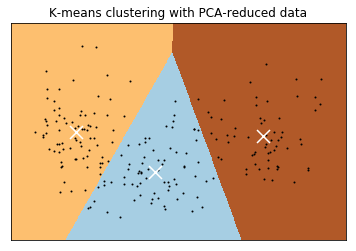

In [31]:
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))

# Obtain labels for each point in mesh
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# Put the result into a color plot
plt.figure(1)
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering with PCA-reduced data')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

Based on sklearn [code](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py).

We can see that data in reduced state is visually separable into three clusters. But the graph is 2-D and gives little information about the real state of data.

### <a name="manyd">High-dimensional data visualization</a>

It is also possible to visualize data having more that two dimensions. 3D plot has three dimensions, size, shape and color may represent three more variables. Let's try.

In [32]:
#I take only 30 samples for better visualization
seeds_little = pd.concat([seeds[50:60],seeds[70:80],seeds[140:150]])

In [33]:
def scatter6d(x,y,z, color, colorsMap='summer'):
    cNorm = matplotlib.colors.Normalize(vmin=min(color), vmax=max(color))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=plt.get_cmap(colorsMap))
    fig = plt.figure()
    ax = Axes3D(fig)
    markers = ['s', 's','o','^']
    for i in seeds.type.unique():
        ax.scatter(x, y, z, c=scalarMap.to_rgba(color), marker=markers[i], s = seeds_little.asymmetry*50 )
    scalarMap.set_array(color)
    fig.colorbar(scalarMap,label='{}'.format('length'))
    plt.show()

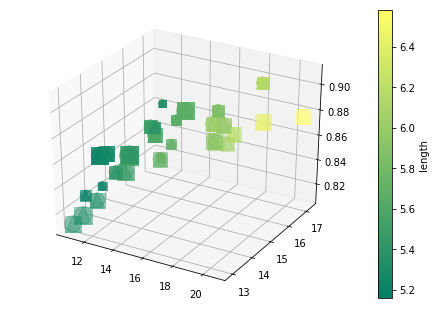

In [34]:
scatter6d(seeds_little.area, seeds_little.perimeter, seeds_little.compactness, seeds_little.length)

Sadly this isn't very representative due to fact that all variables (except type) are numerical. If variables used for size, shape and color were categorical with several values, then the graph could be really used for analysis.

So, if you want to get an overview of high-dimensional data, you could take 2-3 variables and plot them in 2D or 3D. If some variables are categorical, they can be also be used.

This was an overview of K-Means algorithm for data clusterisation. It is a general and simple approach which nonetheless works quite well.
___
Acknowledgements for data as requested:
Lichman, M. (2013). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

Contributors gratefully acknowledge support of their work by the Institute of Agrophysics of the Polish Academy of Sciences in Lublin.